## All stations models

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import re
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
# %run model_utils.ipynb

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

In [3]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv',
         'cunchibamba':'cunchibamba-hgpt_validation.csv'
         }
## cuchimbamba??

In [4]:
def selectCols(df):
  d = dict(zip(df.columns[1:20],df.columns[1:20]+f'_{station[0:3]}'))
  #df = df[['Date_Time', 'ATAvg', 'RHAvg','WDAvg','WSAvg','WAvgx', 'WAvgy','Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]
  df = df[['Date_Time', 'ATAvg', 'RHAvg','WSAvg','WAvgx','Day_sin', 'Day_cos']]
  df.rename(columns=d, inplace= True)
  df.set_index('Date_Time', inplace =True)
  df.index = pd.to_datetime(df.index)
  return df

In [5]:
### combine all stations in one df
for idx, station in enumerate(files_ids.keys()):
    if idx == 0:
        df = pd.read_csv(f'{input_path}/{station}_validation.csv')
        merged = selectCols(df)
    else:
        df1 = pd.read_csv(f'{input_path}/{station}_validation.csv')
        df1 = selectCols(df1)
        merged=pd.merge(merged,df1, how='inner', left_index=True, right_index=True)
    

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
merged.columns

Index(['ATAvg_gua', 'RHAvg_gua', 'WSAvg_gua', 'WAvgx_gua', 'Day_sin_gua',
       'Day_cos_gua', 'ATAvg_ban', 'RHAvg_ban', 'WSAvg_ban', 'WAvgx_ban',
       'Day_sin_ban', 'Day_cos_ban', 'ATAvg_aer', 'RHAvg_aer', 'WSAvg_aer',
       'WAvgx_aer', 'Day_sin_aer', 'Day_cos_aer', 'ATAvg_qui', 'RHAvg_qui',
       'WSAvg_qui', 'WAvgx_qui', 'Day_sin_qui', 'Day_cos_qui', 'ATAvg_chi',
       'RHAvg_chi', 'WSAvg_chi', 'WAvgx_chi', 'Day_sin_chi', 'Day_cos_chi',
       'ATAvg_AJS', 'RHAvg_AJS', 'WSAvg_AJS', 'WAvgx_AJS', 'Day_sin_AJS',
       'Day_cos_AJS', 'ATAvg_JAl', 'RHAvg_JAl', 'WSAvg_JAl', 'WAvgx_JAl',
       'Day_sin_JAl', 'Day_cos_JAl', 'ATAvg_pfc', 'RHAvg_pfc', 'WSAvg_pfc',
       'WAvgx_pfc', 'Day_sin_pfc', 'Day_cos_pfc', 'ATAvg_cal', 'RHAvg_cal',
       'WSAvg_cal', 'WAvgx_cal', 'Day_sin_cal', 'Day_cos_cal', 'ATAvg_mul',
       'RHAvg_mul', 'WSAvg_mul', 'WAvgx_mul', 'Day_sin_mul', 'Day_cos_mul',
       'ATAvg_pam', 'RHAvg_pam', 'WSAvg_pam', 'WAvgx_pam', 'Day_sin_pam',
       'Day_cos_pam', 

In [7]:
merged.head()

,ATAvg_gua,RHAvg_gua,WSAvg_gua,WAvgx_gua,Day_sin_gua,Day_cos_gua,ATAvg_ban,RHAvg_ban,WSAvg_ban,WAvgx_ban,...,WSAvg_pis,WAvgx_pis,Day_sin_pis,Day_cos_pis,ATAvg_cun,RHAvg_cun,WSAvg_cun,WAvgx_cun,Day_sin_cun,Day_cos_cun
Date_Time,,,,,,,,,,,,,,,,,,,,,
2013-05-09 11:45:00,21.708,55.150,4.195,-4.191908,6.540313e-02,-0.997859,23.982,61.768,4.765,-0.759371,...,4.63,-3.217721,6.540313e-02,-0.997859,17.55,64.24,4.21,-2.411445,6.540313e-02,-0.997859
2013-05-09 11:50:00,21.728,53.284,4.195,-4.191908,4.361939e-02,-0.999048,24.292,60.124,4.765,-0.759371,...,4.02,-2.793788,4.361939e-02,-0.999048,17.59,62.67,4.22,-2.417173,4.361939e-02,-0.999048
2013-05-09 11:55:00,22.090,51.676,4.195,-4.191908,2.181489e-02,-0.999762,24.532,59.028,4.765,-0.759371,...,4.36,-3.030079,2.181489e-02,-0.999762,17.69,63.43,4.29,-2.457268,2.181489e-02,-0.999762
2013-05-09 12:00:00,22.190,51.590,4.630,-4.629973,1.373671e-12,-1.000000,24.454,59.820,5.060,-0.907346,...,5.79,-3.925430,1.373671e-12,-1.000000,17.74,65.67,4.16,-2.545388,1.373671e-12,-1.000000
2013-05-09 12:05:00,22.106,50.402,4.630,-4.629973,-2.181489e-02,-0.999762,24.580,59.690,5.060,-0.907346,...,6.03,-4.088142,-2.181489e-02,-0.999762,17.85,64.45,4.20,-2.569863,-2.181489e-02,-0.999762


In [8]:
print(f'len = {len(merged)}')
merged.drop_duplicates(keep = 'first',inplace=True)
print(f'len (after duplicate drop = {len(merged)}')

len = 623263
len (after duplicate drop = 623263


In [9]:
merged.isnull().values.any()

False

In [10]:
#delete outliers an dfill with the meadian value
Q1 = merged.quantile(0.25)
Q3 = merged.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

ATAvg_gua       4.860000
RHAvg_gua      29.450000
WSAvg_gua       3.660000
WAvgx_gua       3.830788
Day_sin_gua     1.414214
                 ...    
RHAvg_cun      27.330000
WSAvg_cun       2.770000
WAvgx_cun       2.108025
Day_sin_cun     1.414214
Day_cos_cun     1.414214
Length: 84, dtype: float64


In [11]:
for i,col in enumerate(merged.columns):
    merged[col] = np.where((merged[col] < (Q1[i] - 1.5 * IQR[i]))|(merged[col] > (Q3[i] + 1.5 * IQR[i])), np.nan, merged[col])

In [12]:
merged.isnull().values.any()

True

In [13]:
merged['month']= merged.index.month
merged['hour']= merged.index.hour
for v in merged.columns:
    merged[v] = merged.groupby(['hour','month'])[v].transform(lambda x: x.fillna(x.median()))


In [14]:
merged.drop(columns=['month','hour'],inplace=True)

In [15]:
merged.isnull().values.any()

False

In [16]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = merged[0::steps]

In [17]:
print(f'starts at = {df.index.min().date()}')
print(f'ends at = {df.index.max().date()}')

starts at = 2013-05-09
ends at = 2019-04-12


In [18]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(df.columns))) 

In [19]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Run models

In [23]:
## read functions
%run model_utils.ipynb

# bacth size 32

In [24]:
station = 'all'
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 32
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps
scaler_type = 'mean'

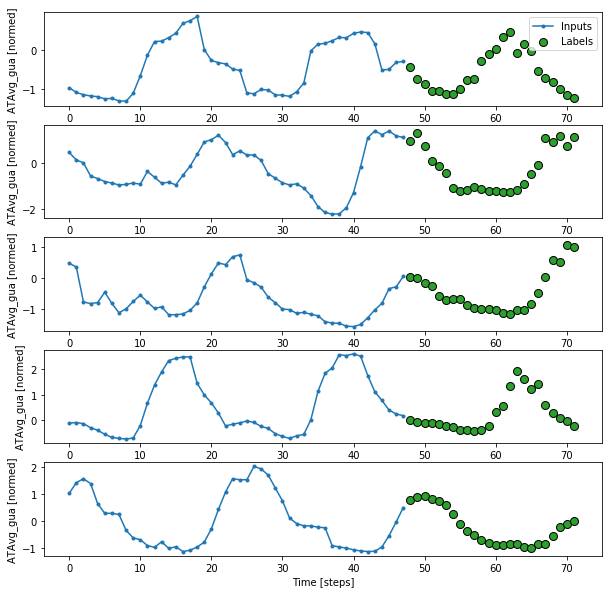

In [25]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

## 1 LSTM layer

In [ ]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=True)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 2 LSTM layers

323/323 [==============================] - 3s 8ms/step - loss: 0.3620 - mean_absolute_error: 0.3753
CPU times: user 29min 53s, sys: 5min, total: 34min 53s
Wall time: 18min 42s


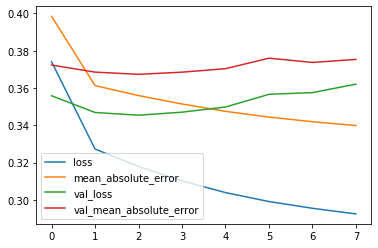

In [28]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

# batch size 64

In [29]:
station = 'all'
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 64
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps
scaler_type = 'mean'

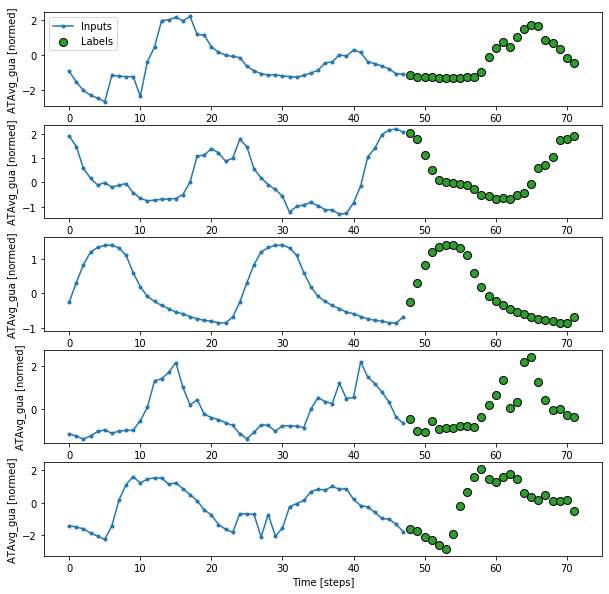

In [30]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

### 1 LSTM layers

162/162 [==============================] - 3s 15ms/step - loss: 0.3506 - mean_absolute_error: 0.3699
CPU times: user 17min 35s, sys: 4min 4s, total: 21min 40s
Wall time: 9min 7s


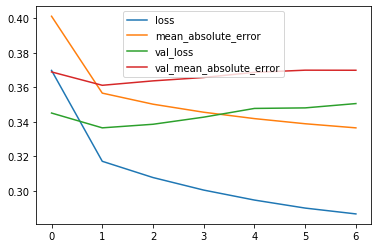

In [31]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 2 LSTM layers

162/162 [==============================] - 4s 22ms/step - loss: 0.3570 - mean_absolute_error: 0.3723
CPU times: user 22min 14s, sys: 5min 10s, total: 27min 25s
Wall time: 11min 27s


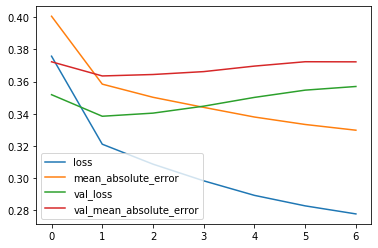

In [32]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

# batch size 128

In [33]:
station = 'all'
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 128
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps
scaler_type = 'mean'

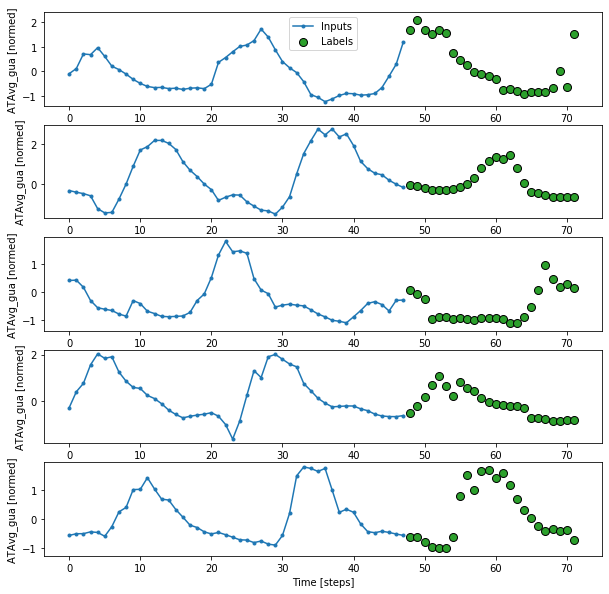

In [34]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

### 1 LSTM layers

81/81 [==============================] - 4s 45ms/step - loss: 0.3441 - mean_absolute_error: 0.3656
CPU times: user 21min 43s, sys: 5min 51s, total: 27min 34s
Wall time: 12min 50s


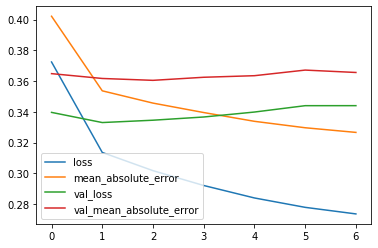

In [35]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 2 LSTM layers

81/81 [==============================] - 7s 88ms/step - loss: 0.3594 - mean_absolute_error: 0.3726
CPU times: user 31min 56s, sys: 9min 53s, total: 41min 49s
Wall time: 17min 30s


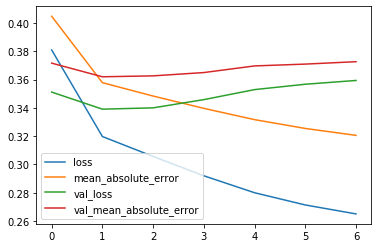

In [36]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

# batch size 256

In [21]:
station = 'all'
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 256
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps
scaler_type = 'mean'

In [22]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

NameError: name 'WindowGenerator' is not defined

### 1 LSTM layers

41/41 [==============================] - 6s 135ms/step - loss: 0.3429 - mean_absolute_error: 0.3617
CPU times: user 27min 54s, sys: 7min 56s, total: 35min 50s
Wall time: 11min 45s


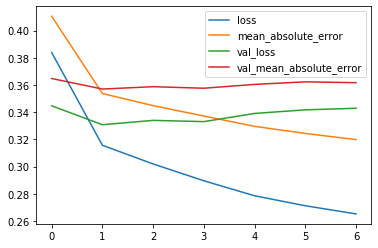

In [39]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 2 LSTM layers

41/41 [==============================] - 8s 196ms/step - loss: 0.3544 - mean_absolute_error: 0.3677
CPU times: user 1h 1min 33s, sys: 16min 20s, total: 1h 17min 53s
Wall time: 17min 35s


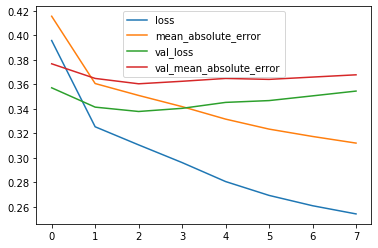

In [40]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')